# **Two-View 3D Reconstruction**

# **Feature Matching**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gdown
from re import S
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation

In [3]:
gdown.download_folder(id="1ROQl0NTBnxMjLrO5qISyxcTCJUPSMsRS", quiet=True, use_cookies=False)

['/content/project3/feature_points.npz',
 '/content/project3/image1.jpg',
 '/content/project3/image2.jpg',
 '/content/project3/intrinsics.npz',
 '/content/project3/monument_reconstruction.gif']

In [4]:
def display_matches(img1, img2, pts1, pts2):
    """
    Visualize the matching points between two images.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Matched points in Image 1 (numpy array of shape Nx2).
        pts2: Matched points in Image 2 (numpy array of shape Nx2).
    """
    img_concat = np.hstack((img1, img2))
    pts2_offset = pts2 + np.array([img1.shape[1], 0])

    plt.imshow(img_concat)
    for pt1, pt2 in zip(pts1, pts2_offset):
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=1)

    plt.axis('off')
    plt.show()

In [5]:
def load_data(image1_path, image2_path,npz_path):
    # load images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # load correspondences
    data = np.load(npz_path)
    pts1 = data['pts1']  # Nx2 array of points in the first image
    pts2 = data['pts2']  # Nx2 array of points in the second image
    return img1, img2,pts1, pts2

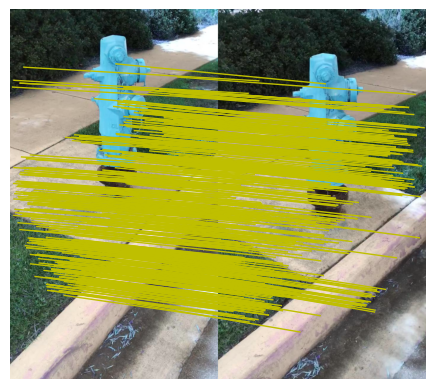

In [6]:
image1_path = '/content/project3/image1.jpg'
image2_path = '/content/project3/image2.jpg'
npz_path = '/content/project3/feature_points.npz'
intrinsics = np.load('/content/project3/intrinsics.npz')
K1 = intrinsics['K1']
K2 = intrinsics['K2']

img1, img2,pts1, pts2 = load_data(image1_path, image2_path,npz_path)

display_matches(img1, img2, pts1, pts2)

# **Fundamental Matrix Estimation and RANSAC**
<img src="https://cmsc733.github.io/assets/2019/p3/ransac.png">

In [7]:
def estimate_Fmatrix(img1_pts, img2_pts):
    """
    Estimate the Fundamental Matrix using matched points from two images.

    Input:
        img1_pts: Matched points from Image 1 (numpy array of shape Nx2).
        img2_pts: Matched points from Image 2 (numpy array of shape Nx2).

    Output:
        F: Estimated Fundamental Matrix (3x3 numpy array).
    """
    A = []
    for i in range(img1_pts.shape[0]):
        x1, y1 = img1_pts[i]
        x2, y2 = img2_pts[i]
        A.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    F_rank_3 = Vt[-1].reshape(3, 3)

    # F rank 2
    U_f, S_f, Vt_f = np.linalg.svd(F_rank_3)
    S_f[-1] = 0  # set the smallest singular value to 0
    F = np.dot(U_f, np.dot(np.diag(S_f), Vt_f))

    return F

In [72]:
def ransac(pts1, pts2, iterations=2500, threshold=0.02):
    """
    Apply RANSAC to estimate the Fundamental Matrix robustly.

    Input:
        pts1: Points from Image 1 (numpy array of shape Nx2).
        pts2: Points from Image 2 (numpy array of shape Nx2).
        iterations: Number of RANSAC iterations (int).
        threshold: Distance threshold

    Output:
        img1_inliers: Inliers from Image 1 (numpy array of shape Mx2).
        img2_inliers: Inliers from Image 2 (numpy array of shape Mx2).
        best_F: Best Fundamental Matrix found (3x3 numpy array).
    """
    n = 0
    best_F = None
    best_inliers = None

    for i in range(iterations):
        indices = np.random.choice(pts1.shape[0], 8, replace=False)
        pts1_sample = pts1[indices]
        pts2_sample = pts2[indices]

        F = estimate_Fmatrix(pts1_sample, pts2_sample)
        S = []

        for j in range(pts1.shape[0]):
            x1 = np.append(pts1[j], 1)
            x2 = np.append(pts2[j], 1)

            err = np.abs(x2.T @ F @ x1)
            if err < threshold:
                S.append(j)

        if n < len(S):
            n = len(S)
            best_F = F
            best_inliers = S

    img1_inliers = pts1[best_inliers]
    img2_inliers = pts2[best_inliers]

    return img1_inliers, img2_inliers, best_F

In [21]:
img1_points, img2_points, F = ransac(pts1, pts2)
print("Fundamental Matrix:\n", F)

Fundamental Matrix:
 [[ 8.22741238e-07  4.72668419e-06 -5.37912738e-03]
 [-2.45397071e-06  5.24511356e-07  8.63953517e-04]
 [ 2.70547449e-03 -2.45903162e-03  9.99978476e-01]]


# **Draw Epipolar Lines**

In [11]:
def compute_epipolar_lines_manual(pts, F):
    """
    Compute epipolar lines for given points using the Fundamental Matrix.

    Input:
        pts: Points in homogeneous coordinates (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        lines: Epipolar lines in homogeneous form (Nx3 numpy array).

    Comments:
        - Converts points to homogeneous coordinates.
        - Computes lines using the Fundamental Matrix.
    """
    homogeneous_pts = np.hstack((pts, np.ones((pts.shape[0], 1))))
    lines = np.dot(F, homogeneous_pts.T).T
    lines /= np.sqrt(lines[:, 0]**2 + lines[:, 1]**2).reshape(-1, 1)
    return lines

def draw_epipolar_lines_img1_points_img2_lines(img1, img2, pts1, F):
    """
    Draw epipolar lines on the second image for points from the first image.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Points in Image 1 (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).
    """
    lines = compute_epipolar_lines_manual(pts1, F)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img1)
    ax[0].set_title("Viewpoint 1 (Points Only)")
    ax[0].axis("off")
    for pt in pts1:
        ax[0].plot(pt[0], pt[1], 'ro')

    ax[1].imshow(img2)
    ax[1].set_title("Viewpoint 2 (Epipolar Lines Only)")
    ax[1].axis("off")
    height, width = img2.shape[:2]
    for line in lines:
        a, b, c = line
        x = np.array([0, width])
        y = -(c + a * x) / b
        y = np.clip(y, 0, height - 1)
        ax[1].plot(x, y, color='blue', linewidth=1)

    plt.tight_layout()
    plt.show()

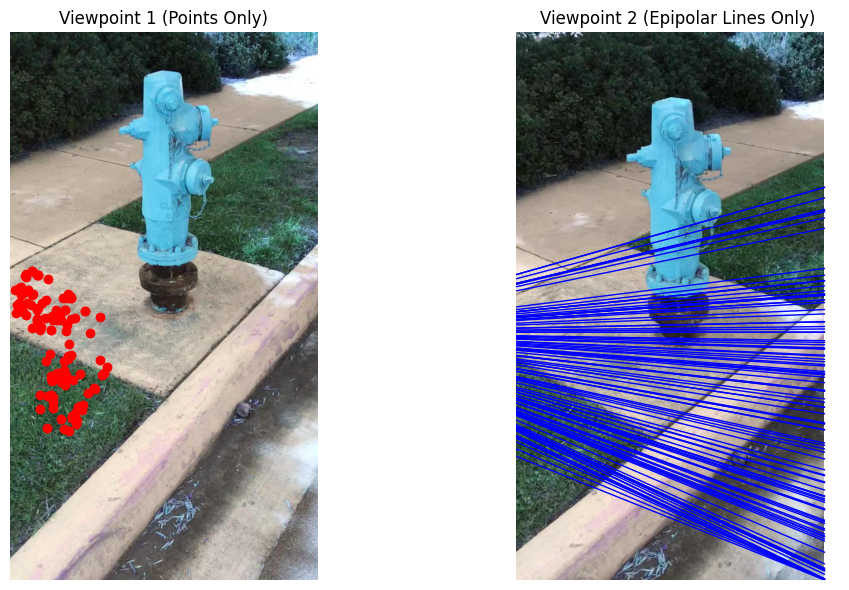

In [ ]:
draw_epipolar_lines_img1_points_img2_lines(img1, img2, img1_points, F)

# **Estimate Essential Matrix E**



In [12]:
def estimate_Essentialmatrix(K1, K2, F):
    """
    Estimate the Essential Matrix using camera intrinsics and the Fundamental Matrix.

    Input:
        K1: Intrinsic matrix of Camera 1 (3x3 numpy array).
        K2: Intrinsic matrix of Camera 2 (3x3 numpy array).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        E: Estimated Essential Matrix (3x3 numpy array).

    Comments:
        - Computes the Essential Matrix as E = K2.T * F * K
    """
    E = K2.T @ F @ K1
    U, S, Vt = np.linalg.svd(E)
    S[-1] = 0
    # calibrating E
    E = U @ np.diag(S) @ Vt
    return E

In [26]:
E = estimate_Essentialmatrix(K1, K2, F)
print("Essential Matrix E:\n", E)

Essential Matrix E:
 [[ 1.22117238  7.01568845 -2.60232405]
 [-3.64236181  0.7785179   0.40122782]
 [ 1.77188947 -0.57312773 -0.12925431]]


# **Extracting Poses from E**
<img src = "https://drive.google.com/uc?export=view&id=1vizqzdm0gB4sRWQSrvZZPjwezW2OG5tE">




In [14]:
def get_RTset(E):
    """
    Extract possible sets of rotation (R) and translation (T) from the Essential Matrix.

    Input:
        E: Essential Matrix (3x3 numpy array).

    Output:
        R: List of possible rotation matrices (4x 3x3 numpy arrays).
        T: List of possible translation vectors (4x 3x1 numpy arrays).

    Comments:
        - Uses SVD decomposition of the Essential Matrix.
        - Constructs four possible (R, T) pairs and ensures valid rotations

    """
    # transformation matrix
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    U, S, Vt = np.linalg.svd(E)

    # camera centers
    C1 = U[:, 2]
    C2 = -U[:, 2]
    C3 = U[:, 2]
    C4 = -U[:, 2]

    # rotation matrices
    R1 = U @ W @ Vt
    R2 = U @ W @ Vt
    R3 = U @ W.T @ Vt
    R4 = U @ W.T @ Vt

    # handle negative R determinate
    if np.linalg.det(R1) < 0:
        C1 *= -1
    if np.linalg.det(R2) < 0:
        C2 *= -1
    if np.linalg.det(R3) < 0:
        C3 *= -1
    if np.linalg.det(R4) < 0:
        C4 *= -1

    R_Set = [R1, R2, R3, R4]
    T_Set = [C1, C2, C3, C4]
    return R_Set, T_Set

In [27]:
R_Set, T_Set = get_RTset(E)

# **Linear Triangulation**


In [16]:

def linear_triangulation(R_Set, T_Set, pt1, pt2, k):
    """
    Perform linear triangulation to estimate 3D points.

    Input:
        R_Set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_Set: List of possible translation vectors (4x 3x1 numpy arrays).
        pt1: Points in Image 1 (numpy array of shape Nx2).
        pt2: Points in Image 2 (numpy array of shape Nx2).
        k: Camera intrinsic matrix (3x3 numpy array).

    Output:
        points_3d_set: List of 3D points for each (R, T) pair.

    Comments:
        - Triangulates 3D points for each (R, T) pair.
    """
    points_3d_set = []

    # homogeneous coordinates
    pts1_h = np.hstack((pt1, np.ones((pt1.shape[0], 1))))
    pts2_h = np.hstack((pt2, np.ones((pt2.shape[0], 1))))

    # first camera matrix
    P1 = k @ np.hstack((np.eye(3), np.zeros((3, 1))))

    for R, T in zip(R_Set, T_Set):
        # second camera matrix
        T = T.reshape(3, 1)
        P2 = k @ np.hstack((R, T))
        points_3d = []

        for x1, x2 in zip(pts1_h, pts2_h):
            A = np.vstack([
                x1[0] * P1[2, :] - P1[0, :],
                x1[1] * P1[2, :] - P1[1, :],
                x2[0] * P2[2, :] - P2[0, :],
                x2[1] * P2[2, :] - P2[1, :]
            ])
            _, _, Vt = np.linalg.svd(A)
            X = Vt[-1]
            X /= X[3] # non-homogeneous coordinate
            points_3d.append(X[:3])

        points_3d_set.append(points_3d)

    return points_3d_set

# **Cheriality Condition**

In [17]:
def extract_pose(R_set, T_set, pts_3d_set):
    """
    Select the best pose (R, T) that satisfies the chirality condition.

    Input:
        R_set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_set: List of possible translation vectors (4x 3x1 numpy arrays).
        pts_3d_set: List of 3D point sets for each (R, T) pair.

    Output:
        R_best: Best rotation matrix (3x3 numpy array).
        T_best: Best translation vector (3x1 numpy array).
        X_best: Best 3D points (Nx3 numpy array).
        index: Index of the best (R, T) pair.
    """
    best_count = -1
    R_best, T_best, X_best = None, None, None
    index = -1

    for i, (R, T, pts_3d) in enumerate(zip(R_set, T_set, pts_3d_set)):
        T = T.reshape(3, 1)

        count = 0
        for X in pts_3d:
            X_h = np.append(X, 1)
            z1 = X_h[2]

            X_2 = R @ X + T.flatten()
            z2 = X_2[2]

            if z1 > 1e-3 and z2 > 1e-3:
                count += 1

        if count > best_count:
            best_count = count
            R_best, T_best, X_best = R, T, pts_3d
            index = i

    return R_best, T_best, X_best, index


In [18]:
def compute_cheriality(pt, r3, t):
    """
    Compute the chirality condition to determine if points are in front of the camera.

    Input:
        pt: 3D points (Nx3 numpy array).
        r3: Third row of the rotation matrix (1x3 numpy array).
        t: Translation vector (3x1 numpy array).

    Output:
        count_depth: Number of points with positive depth.
    """
    depth = np.dot(pt, r3.T) + t.flatten()
    count = np.sum(depth > 0)
    return count

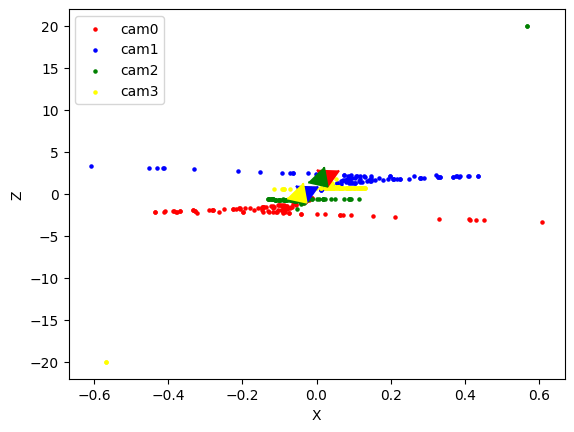

In [74]:
point3D_set = linear_triangulation(R_Set,T_Set,img1_points,img2_points,K1)

fig, ax = plt.subplots()
camera_colors = ['red', 'blue', 'green', 'yellow']

# plot 2D points on X-Z plane
for i, points_3d in enumerate(point3D_set):
    points_3d = np.array(points_3d)
    ax.scatter(points_3d[:, 0], points_3d[:, 2], s=5, c=camera_colors[i], label=f"cam{i}")

# plot camera poses on X-Z plane
for i in range(len(R_Set)):
    R = Rotation.from_matrix(R_Set[i]).as_rotvec()
    R1 = np.rad2deg(R)

    t = mpl.markers.MarkerStyle(marker=mpl.markers.CARETDOWN)
    t._transform = t.get_transform().rotate_deg(int(R1[1]))

    ax.scatter(T_Set[i][0], T_Set[i][2], marker=t, s=250, c=camera_colors[i])

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.legend()
plt.show()

In [75]:
R_best, T_best,X_ ,index= extract_pose(R_Set,T_Set, point3D_set)

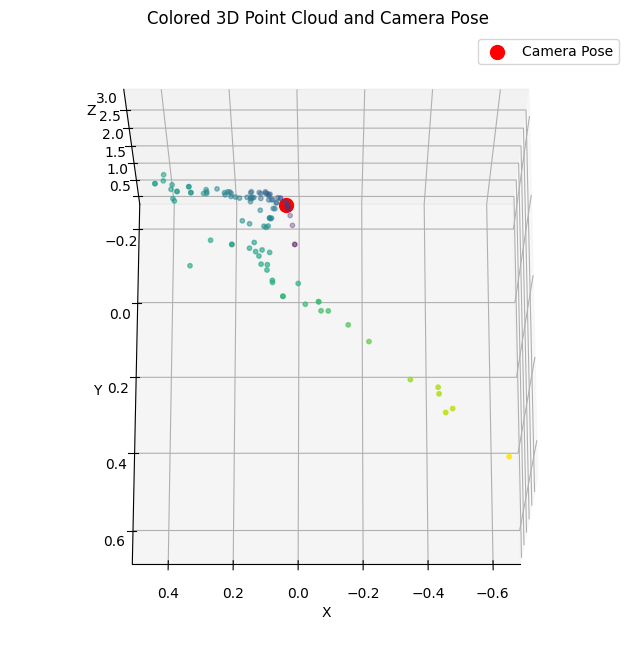

In [76]:
def plot_top_down_3d_point_cloud(points_3d, R, T):
    """
    Plot the 3D point cloud with a top-down view.

    Input:
        points_3d: Nx3 numpy array of 3D points.
        R: Best rotation matrix (3x3 numpy array).
        T: Best translation vector (3x1 numpy array).
    """
    points_3d = np.array(points_3d)

    # normalize Z for color mapping
    z_vals = points_3d[:, 2]
    colors = (z_vals - z_vals.min()) / (z_vals.max() - z_vals.min())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
        c=colors, cmap='viridis', s=10
    )

    # camera pose
    camera_center = -R.T @ T.flatten()
    ax.scatter(camera_center[0], camera_center[1], camera_center[2],
               c='red', label='Camera Pose', s=100, marker='o')

    ax.view_init(70, 90)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Colored 3D Point Cloud and Camera Pose')

    plt.legend()
    plt.show()

plot_top_down_3d_point_cloud(X_, R_best, T_best)

**Step 1: Feature Matching** \\
I start by finding matching points based on similar features.

**Step 2: Fundamental Matrix Estimation and RANSAC** \\
Next, I estimate the Fundamental Matrix using 8 corresponding points. I calculate the matrix from a set of matched points and then refine the result using RANSAC to eliminate outliers. This involves repeatedly selecting random subsets of points, computing the fundamental matrix for each subset, and finding the one with the most inliers that satisfy the epipolar constraint. Using the points from the first image and the fundamental matrix, I compute the corresponding epipolar lines in the second image. To do this, I convert the points to homogeneous coordinates, apply the fundamental matrix, and normalize the resulting lines.

**Step 3: Estimate E** \\
I calculate the essential matrix using the fundamental matrix and the camera’s intrinsic matrices. The final matrix describes the relationship between corresponding points in the two images.

**Step 4: Extracting Poses from E** \\
From the essential matrix, I extract the possible rotation matrices and translation vectors. Using SVD, I decompose E to determine the camera centers and generate four possible rotation matrices by combining the decomposition with a transformation matrix. If any rotation matrix has a negative determinant, I flip the corresponding translation vector. This gives me four potential rotation and translation pairs, each representing different camera positions.

**Step 5: Linear Triangulation** \\
I use the multiple camera positions, 2D points, and the camera’s intrinsic matrix to perform linear triangulation. For each pose, I create a camera matrix and set up a system of equations based on the 2D points. By solving this system using SVD, I determine the corresponding 3D points. I repeat this process for each camera pose and get a list of potential 3D reconstructions.

**Step 6: Chirality Condition** \\
Finally, I triangulate potential 3D points using the corresponding 2D points from both images. I select the best camera pose by applying the chirality condition, making sure the 3D points are in front of both cameras. To do this, I check if the 3D points have positive depth in both views.